In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
game_events = pd.read_csv('game_events.csv')

In [3]:
def assign_interval(row):
    if row['minute'] <= 22:
        return '0-22 min'
    elif row['minute'] <= 45:
        return '23-45 min'
    elif row['minute'] <= 68:
        return '46-68 min'
    elif row['minute'] < 90:
        return '69-89 min'
    elif row['minute'] == 90:
        return 'Added Time (90+ min)'
    else:
        return 'Extra Time'

# Assign intervals
game_events['interval'] = game_events.apply(assign_interval, axis=1)
game_events = game_events[game_events['interval'] != 'Extra Time']

# filter for goals only
goals = game_events[game_events['type'] == 'Goals'].copy()
last_goals = goals.loc[goals.groupby('game_id')['minute'].idxmax()]

In [4]:
# Identify result-altering goals
def is_result_altering_goal(row, match_goals):
    game_id = row['game_id']
    club_id = row['club_id']
    minute = row['minute']
    
    # Filter goals for the current match
    match_goals = match_goals[match_goals['game_id'] == game_id].sort_values('minute').reset_index(drop=True)
    if match_goals.empty: 
      return False

    # Calculate cumulative scores for each team
    match_goals['team_score'] = match_goals.groupby('club_id').cumcount() + 1
    match_goals['opponent_score'] = match_goals.groupby('game_id').transform('sum')['team_score'] - match_goals['team_score']

    # Get scores before and after this goal
    current_position = match_goals[match_goals['minute'] == minute].index[0]
    pre_goal_score_team = match_goals.iloc[current_position - 1]['team_score'] if current_position > 0 else 0
    pre_goal_score_opponent = match_goals.iloc[current_position - 1]['opponent_score'] if current_position > 0 else 0
    post_goal_score_team = match_goals.iloc[current_position]['team_score']
    post_goal_score_opponent = match_goals.iloc[current_position]['opponent_score']

    # Determine if this goal altered the result
    pre_goal_result = "draw" if pre_goal_score_team == pre_goal_score_opponent else ("win" if pre_goal_score_team > pre_goal_score_opponent else "loss")
    post_goal_result = "draw" if post_goal_score_team == post_goal_score_opponent else ("win" if post_goal_score_team > post_goal_score_opponent else "loss")
    
    return pre_goal_result != post_goal_result


In [5]:
last_goals['is_result_altering'] = last_goals.apply(is_result_altering_goal, axis=1, match_goals=goals)

In [6]:
# Group by interval and calculate the percentage of result-altering goals
interval_stats = last_goals.groupby('interval').agg(
    result_altering_goals=('is_result_altering', 'sum')
).reset_index()

total_result_altering_goals = interval_stats['result_altering_goals'].sum()

interval_stats['result_altering_goal_percentage'] = (
    interval_stats['result_altering_goals'] / total_result_altering_goals * 100
)
interval_stats

,interval,result_altering_goals,result_altering_goal_percentage
0,0-22 min,2621,7.100480
1,23-45 min,5392,14.607320
2,46-68 min,9424,25.530301
3,69-89 min,14327,38.812884
4,Added Time (90+ min),5149,13.949015


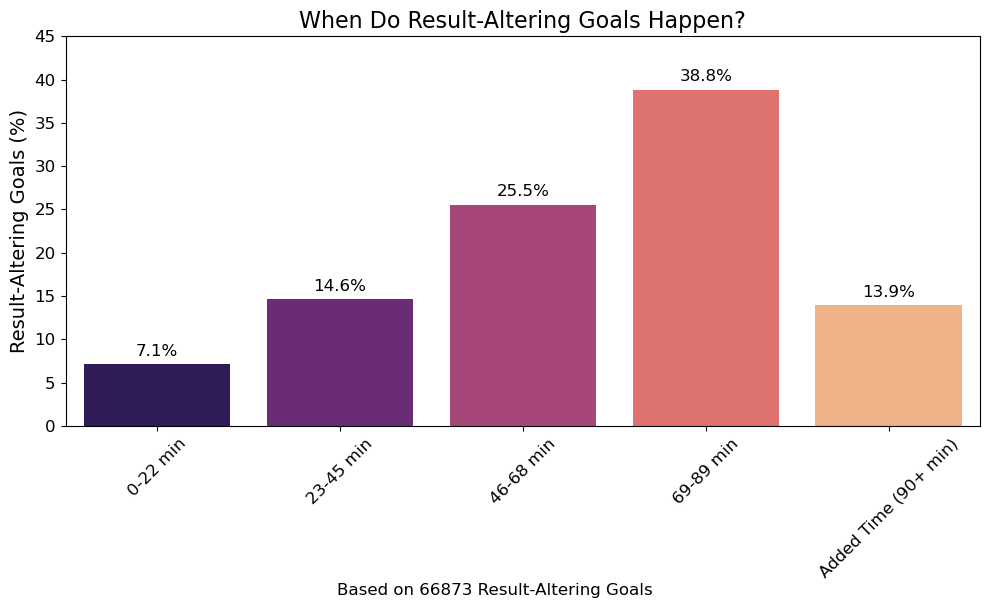

In [7]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(
    data=interval_stats,
    x="interval",
    y="result_altering_goal_percentage",
    hue="interval",
    palette="magma"
)

plt.ylim(0, 45)
plt.title("When Do Result-Altering Goals Happen?", fontsize=16)
total_goals = len(last_goals)
plt.figtext(0.5, 0, f"Based on {total_goals} Result-Altering Goals", wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel("")
plt.ylabel("Result-Altering Goals (%)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for index, row in interval_stats.iterrows():
    plt.text(index, row['result_altering_goal_percentage'] + 1, f"{row['result_altering_goal_percentage']:.1f}%", 
             ha='center', fontsize=12)

plt.tight_layout()
plt.show()


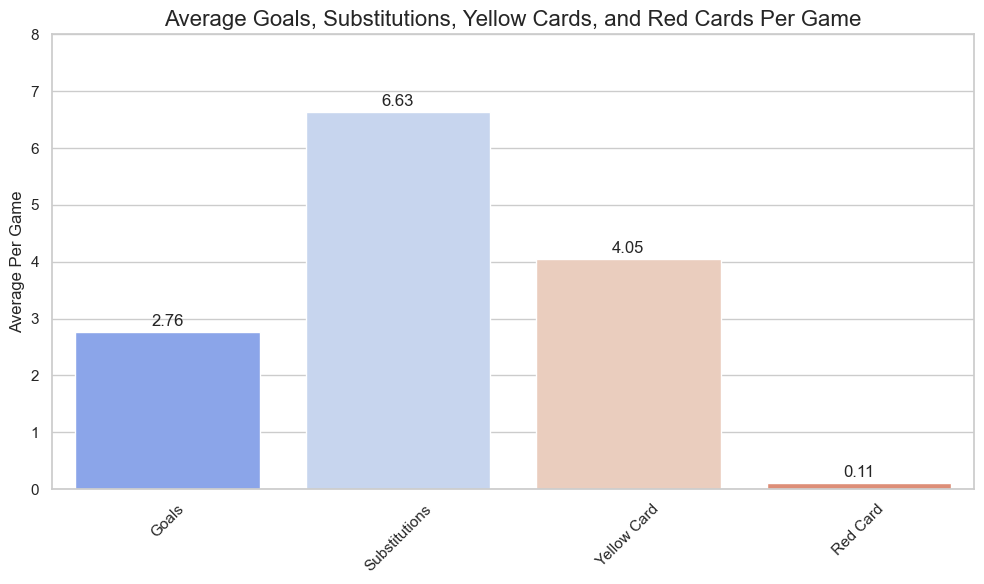

In [8]:
# Filter relevant event types and extract Yellow and Red cards
game_events['Yellow Card'] = game_events['description'].str.contains('Yellow card', case=False, na=False).astype(int)
game_events['Red Card'] = game_events['description'].str.contains('Red card', case=False, na=False).astype(int)

# Include only relevant types
filtered_events = game_events[game_events['type'].isin(['Goals', 'Substitutions'])]

# Aggregate by game_id
event_counts = filtered_events.groupby(['game_id', 'type']).size().unstack(fill_value=0)
event_counts['Yellow Card'] = game_events.groupby('game_id')['Yellow Card'].sum()
event_counts['Red Card'] = game_events.groupby('game_id')['Red Card'].sum()
average_events_per_game = event_counts.mean()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_events_per_game.index, y=average_events_per_game.values, hue=average_events_per_game.index, palette='coolwarm')

# Annotate the exact values on top of each bar
for i, value in enumerate(average_events_per_game.values):
    ax.text(i, value + 0.1, f'{value:.2f}', ha='center', fontsize=12)

plt.title('Average Goals, Substitutions, Yellow Cards, and Red Cards Per Game', fontsize=16)
plt.xlabel('')
plt.ylabel('Average Per Game', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 8)
plt.tight_layout()
plt.show()


In [9]:
game_events

,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id,interval,Yellow Card,Red Card
0,2f41da30c471492e7d4a984951671677,2012-08-05,2211607,77,Cards,610,4425,"1. Yellow card , Mass confrontation",NaN,NaN,69-89 min,1,0
1,a72f7186d132775f234d3e2f7bc0ed5b,2012-08-05,2211607,77,Cards,383,33210,"1. Yellow card , Mass confrontation",NaN,NaN,69-89 min,1,0
2,b2d721eaed4692a5c59a92323689ef18,2012-08-05,2211607,3,Goals,383,36500,", Header, 1. Tournament Goal Assist: , Corner,...",NaN,56416.0,0-22 min,0,0
3,aef768899cedac0c9a650980219075a2,2012-08-05,2211607,53,Goals,383,36500,", Right-footed shot, 2. Tournament Goal Assist...",NaN,146258.0,46-68 min,0,0
4,5d6d9533023057b6619ecd145a038bbe,2012-08-05,2211607,74,Substitutions,383,36500,", Not reported",49499.0,NaN,69-89 min,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005920,51813fd850c6900dbf0de2fde9f46432,2024-12-16,4511856,61,Cards,26459,382895,"3. Yellow card , Foul",NaN,NaN,46-68 min,1,0
1005921,3566061cef1704c620cac3b4ce288e40,2024-12-16,4511856,23,Goals,338,631821,", Right-footed shot, 10. Goal of the Season As...",NaN,167722.0,23-45 min,0,0
1005922,e71de2a850045330ad17446d6bf47a98,2024-12-16,4511856,73,Substitutions,26459,688714,", Tactical",520400.0,NaN,69-89 min,0,0
1005923,a41496547c44fa261f5dfd7506700171,2024-12-16,4511856,90,Substitutions,26459,819249,", Tactical",718123.0,NaN,Added Time (90+ min),0,0
